In [ ]:
# If you are using colab, uncomment this cell

!wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_03_linear_classification/notmnist.py

--2023-09-23 16:15:59--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_03_linear_classification/notmnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1848 (1.8K) [text/plain]
Saving to: ‘notmnist.py’

notmnist.py         100%[===================>]   1.80K  --.-KB/s    in 0s      

2023-09-23 16:15:59 (15.4 MB/s) - ‘notmnist.py’ saved [1848/1848]



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
torch.__version__

'2.1.0+cu121'

In [ ]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n%s\n" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s\n" % (x + 5))
print("X*X^T  :\n%s\n" % np.dot(x, x.T))
print("mean over cols :\n%s\n" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s\n" % (np.cumsum(x, axis=0)))

X :
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

X.shape : (4, 4)

add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]

X*X^T  :
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]

mean over cols :
[ 1.5  5.5  9.5 13.5]

cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]



In [ ]:
# pytorch world

x = np.arange(16).reshape(4, 4)

x = torch.tensor(x, dtype=torch.float32)  # or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s\n" % (x + 5))
print("X*X^T  :\n%s\n" % torch.matmul(x, x.transpose(1, 0)))  # short: x.mm(x.t())
print("mean over cols :\n%s\n" % torch.mean(x, dim=-1))
print("cumsum of cols :\n%s" % torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
X.shape : torch.Size([4, 4])

add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])

X*X^T  :
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])

mean over cols :
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])

cumsum of cols :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


#### NumPy and Pytorch

As you can notice, pytorch allows you to hack stuff much the same way you did with numpy. This means that you can _see the numeric value of any tensor at any moment of time_. Debugging such code can be done with by printing tensors or using any debug tool you want (e.g. [gdb](https://wiki.python.org/moin/DebuggingWithGdb)).

You could also notice the a few new method names and a different API. So no, there's no compatibility with numpy [yet](https://github.com/pytorch/pytorch/issues/2228) and yes, you'll have to memorize all the names again. Get excited!

![img](http://i0.kym-cdn.com/entries/icons/original/000/017/886/download.jpg)

For example,
* If something takes a list/tuple of axes in numpy, you can expect it to take *args in pytorch
 * `x.reshape([1,2,8]) -> x.view(1,2,8)`
* You should swap _axis_ for _dim_ in operations like mean or cumsum
 * `x.sum(axis=-1) -> x.sum(dim=-1)`
* most mathematical operations are the same, but types an shaping is different
 * `x.astype('int64') -> x.type(torch.LongTensor)`

To help you acclimatize, there's a [table](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users) covering most new things. There's also a neat [documentation page](http://pytorch.org/docs/master/).

Finally, if you're stuck with a technical problem, we recommend searching [pytorch forumns](https://discuss.pytorch.org/). Or just googling, which usually works just as efficiently.

If you feel like you almost give up, remember two things: __GPU__ and __free gradients__. Besides you can always jump back to numpy with x.numpy()

## Warmup: trigonometric knotwork

_inspired by [this post](https://www.quora.com/What-are-the-most-interesting-equation-plots)_

There are some simple mathematical functions with cool plots. For one, consider this:

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$


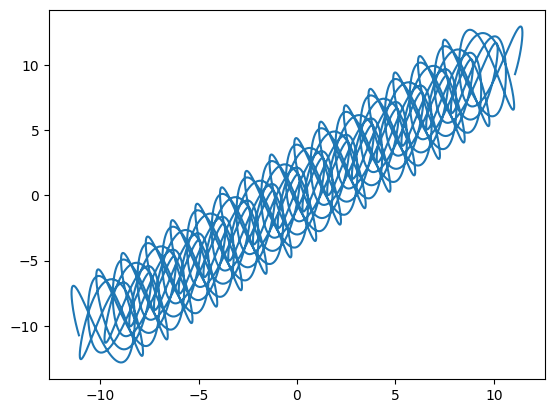

In [ ]:
t = torch.linspace(-10, 10, steps=10000)

# compute x(t) and y(t) as defined above
x  = t-1.5* torch.sin(15*t) #None  # YOUR CODE HERE
y = t-3* torch.cos(25*t) # None  # YOUR CODE HERE

plt.plot(x.numpy(), y.numpy())

if you're done early, try adjusting the formula and seing how  it affects the function

## Automatic gradients

Any self-respecting DL framework must do your backprop for you. Torch handles this with the `autograd` module.

The general pipeline looks like this:
* When creating a tensor, you mark it as `requires_grad`:
    * __```torch.zeros(5, requires_grad=True)```__
    * torch.tensor(np.arange(5), dtype=torch.float32, requires_grad=True)
* Define some differentiable `loss = arbitrary_function(a)`
* Call `loss.backward()`
* Gradients are now available as ```a.grads```

__Here's an example:__ let's fit a linear regression on Boston house prices

In [ ]:
import torch

In [ ]:
torch.manual_seed(6)
x = torch.randn(4, 4, requires_grad=True)
y = torch.randn(4, 4, requires_grad=True)
z = x * y
l = z.sum()
l.backward()
print(x.grad)
print(y.grad)

tensor([[-1.4801, -1.0631,  0.3630,  0.3995],
        [ 0.1457, -0.7345, -0.9873,  1.8512],
        [-1.3437,  0.8535,  0.8811, -0.6522],
        [ 0.5810,  0.3561,  0.0160,  0.4019]])
tensor([[-1.2113,  0.6304, -1.4713, -1.3352],
        [-0.4897,  0.1317,  0.3295,  0.3264],
        [-0.4806,  1.1032,  2.5485,  0.3006],
        [-0.5432, -1.0841,  1.4612, -1.6279]])


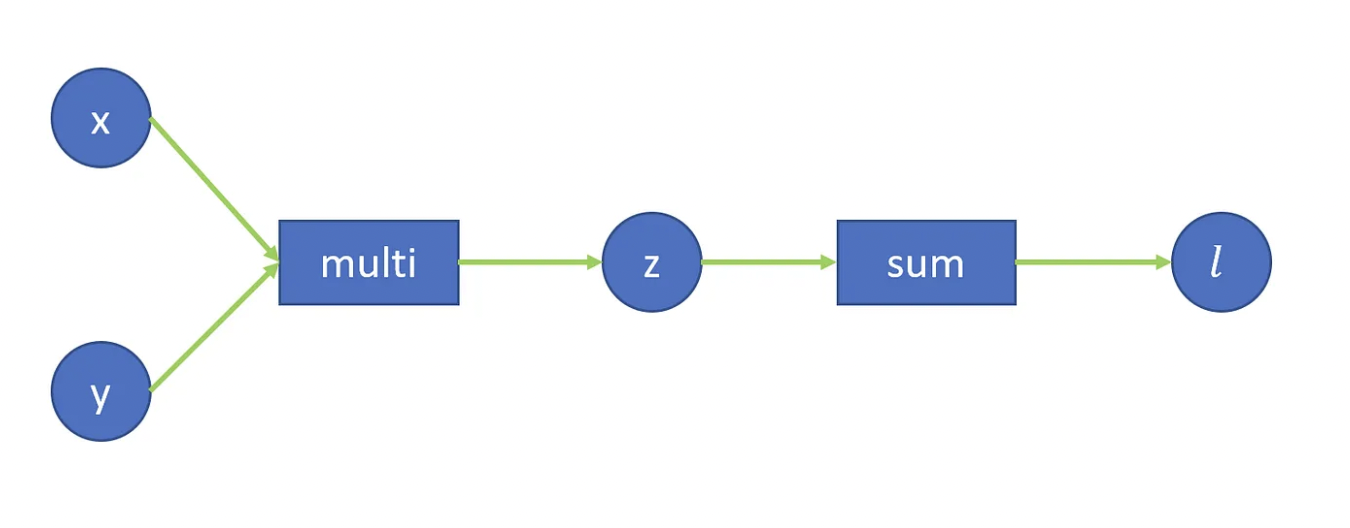

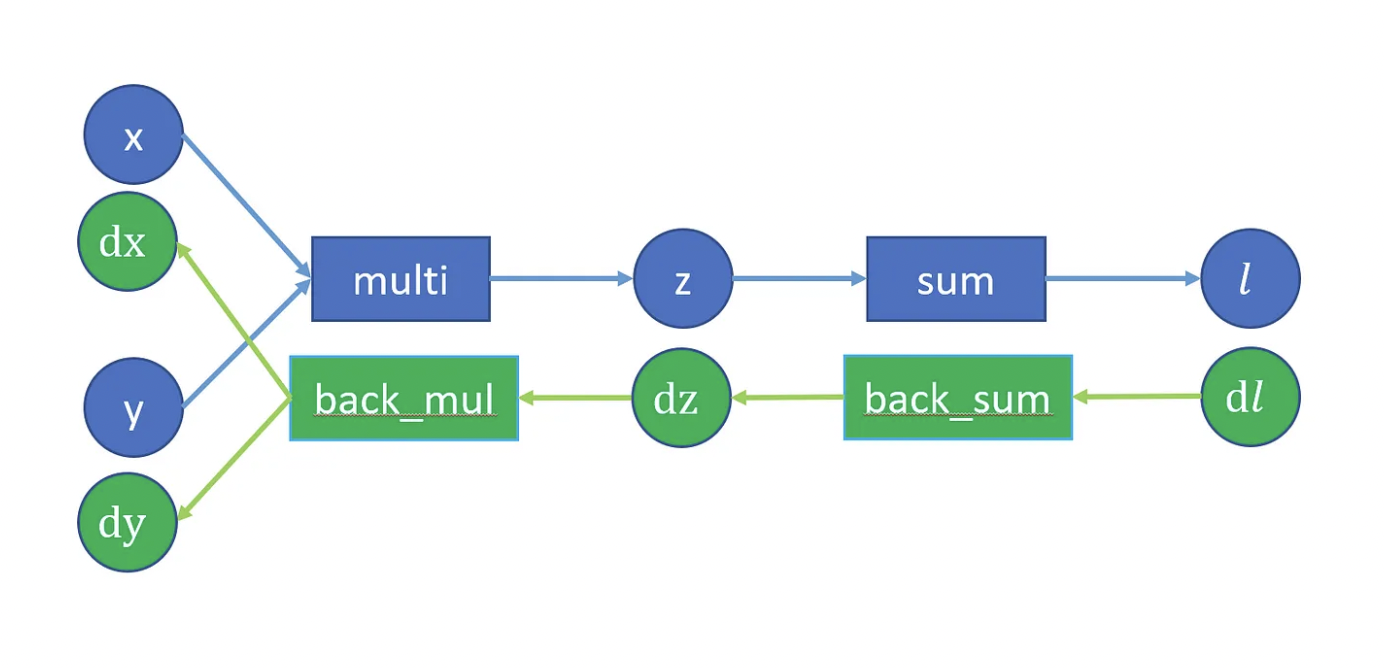

In [ ]:
torch.manual_seed(6)
x = torch.randn(4, 4, requires_grad=True)
y = torch.randn(4, 4, requires_grad=True)
z = x * y
l = z.sum()
dl = torch.tensor(1.)
back_sum = l.grad_fn
dz = back_sum(dl)
back_mul = back_sum.next_functions[0][0]
dx, dy = back_mul(dz)
back_x = back_mul.next_functions[0][0]
back_x(dx)
back_y = back_mul.next_functions[1][0]
back_y(dy)
print(x.grad)
print(y.grad)

tensor([[-1.4801, -1.0631,  0.3630,  0.3995],
        [ 0.1457, -0.7345, -0.9873,  1.8512],
        [-1.3437,  0.8535,  0.8811, -0.6522],
        [ 0.5810,  0.3561,  0.0160,  0.4019]], grad_fn=<CopyBackwards>)
tensor([[-1.2113,  0.6304, -1.4713, -1.3352],
        [-0.4897,  0.1317,  0.3295,  0.3264],
        [-0.4806,  1.1032,  2.5485,  0.3006],
        [-0.5432, -1.0841,  1.4612, -1.6279]], grad_fn=<CopyBackwards>)


## Differentiation in Autograd
Let's take a look at how ``autograd`` collects gradients. We create two tensors ``a`` and ``b`` with
``requires_grad=True``. This signals to ``autograd`` that every operation on them should be tracked.




In [ ]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor ``Q`` from ``a`` and ``b``.

\begin{align}Q = 3a^3 - b^2\end{align}



In [ ]:
Q = 3*a**3 - b**2

In [ ]:
Q.grad_fn

Let's assume ``a`` and ``b`` to be parameters of an NN, and ``Q``
to be the error. In NN training, we want gradients of the error
w.r.t. parameters, i.e.

\begin{align}\frac{\partial Q}{\partial a} = 9a^2\end{align}

\begin{align}\frac{\partial Q}{\partial b} = -2b\end{align}


When we call ``.backward()`` on ``Q``, autograd calculates these gradients
and stores them in the respective tensors' ``.grad`` attribute.

We need to explicitly pass a ``gradient`` argument in ``Q.backward()`` because it is a vector.
``gradient`` is a tensor of the same shape as ``Q``, and it represents the
gradient of Q w.r.t. itself, i.e.

\begin{align}\frac{dQ}{dQ} = 1\end{align}

Equivalently, we can also aggregate Q into a scalar and call backward implicitly, like ``Q.sum().backward()``.




In [ ]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

Gradients are now deposited in ``a.grad`` and ``b.grad``



In [ ]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)


[Learn the Basics](intro.html) ||
[Quickstart](quickstart_tutorial.html) ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
**Optimization** ||
[Save & Load Model](saveloadrun_tutorial.html)

# Optimizing Model Parameters

Now that we have a model and data it's time to train, validate and test our model by optimizing its parameters on
our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates
the error in its guess (*loss*), collects the derivatives of the error with respect to its parameters (as we saw in
the [previous section](autograd_tutorial.html)), and **optimizes** these parameters using gradient descent. For a more
detailed walkthrough of this process, check out this video on [backpropagation from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8)_.

## Prerequisite Code
We load the code from the previous sections on [Datasets & DataLoaders](data_tutorial.html)
and [Build Model](buildmodel_tutorial.html).


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

## Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process.
Different hyperparameter values can impact model training and convergence rates
([read more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)_ about hyperparameter tuning)

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.




In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each
iteration of the optimization loop is called an **epoch**.

Each epoch consists of two main parts:
 - **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
 - **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to
see the `full-impl-label` of the optimization loop.

### Loss Function

When presented with some training data, our untrained network is likely not to give the correct
answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value,
and it is the loss function that we want to minimize during training. To calculate the loss we make a
prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output logits to ``nn.CrossEntropyLoss``, which will normalize the logits and compute the prediction error.



In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).
All optimization logic is encapsulated in  the ``optimizer`` object. Here, we use the SGD optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html)
available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.



In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
 * Call ``optimizer.zero_grad()`` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to ``loss.backward()``. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.




## Full Implementation
We define ``train_loop`` that loops over our optimization code, and ``test_loop`` that
evaluates the model's performance against our test data.



In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to ``train_loop`` and ``test_loop``.
Feel free to increase the number of epochs to track the model's improving performance.



In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

## Further Reading
- [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [torch.optim](https://pytorch.org/docs/stable/optim.html)
- [Warmstart Training a Model](https://pytorch.org/tutorials/recipes/recipes/warmstarting_model_using_parameters_from_a_different_model.html)




# Nueral network


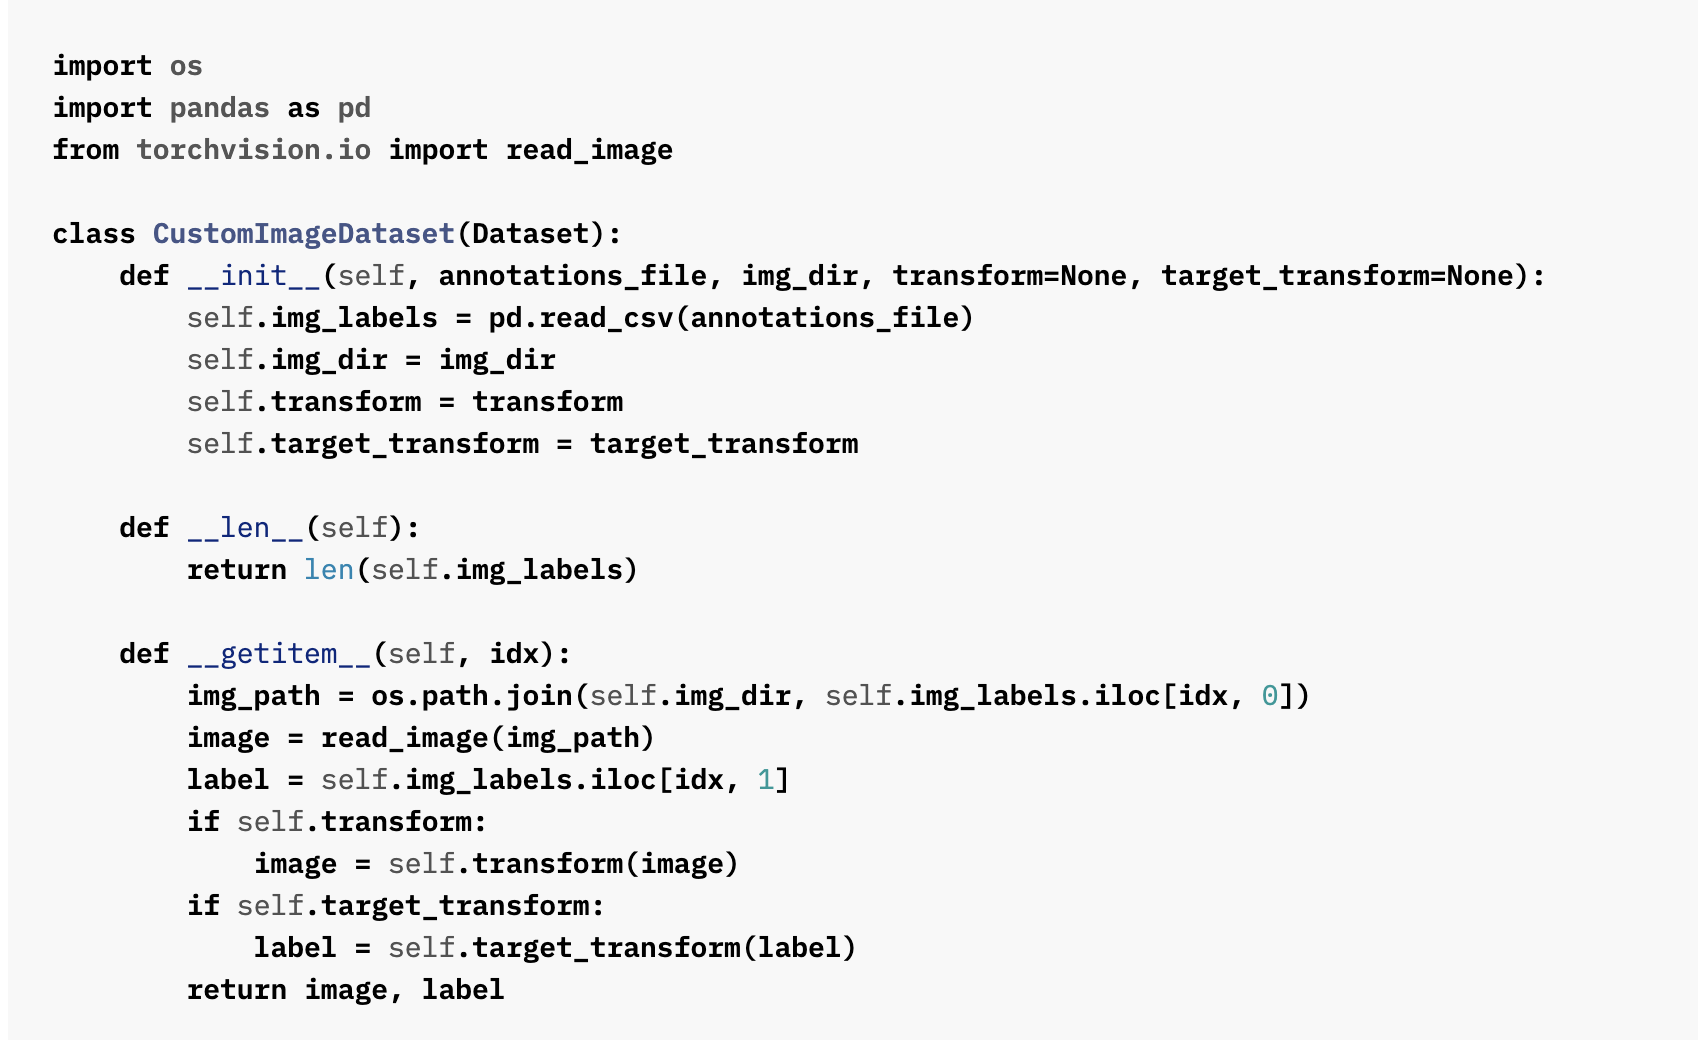

In [ ]:
# do not change the code in the block below
# __________start of block__________
import numpy as np
import os
import time


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure



out_dict = dict()

# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

download = True
train_transform = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.RandomPerspective(),
    transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
 ])

# transforms.Commpose([transforms.CenterCrop(10),
#                                         transforms.RandomVerticalFlip(p=0.5),
#                                        transforms.ToTensor()])
test_transform = transforms.Compose([transforms.RandomRotation(180),
                                    transforms.RandomPerspective(),
                                        transforms.RandomVerticalFlip(p=0.5),
                                       transforms.ToTensor()])


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

# __________end of block__________

Directory fmnist is created!


100%|██████████| 26421880/26421880 [00:00<00:00, 117287081.94it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 7345133.65it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 63248343.93it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3664055.15it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



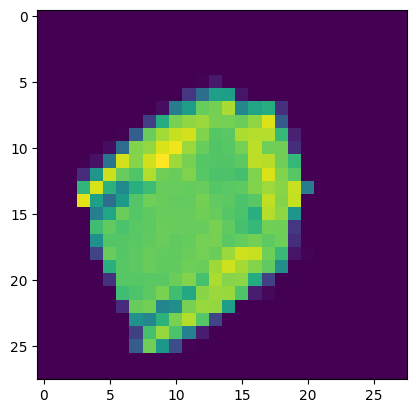

In [ ]:
plt.imshow(fmnist_dataset_train.__getitem__(24)[0].numpy()[0,:,:])

In [ ]:
fmnist_dataset_train.__getitem__(23)[1]

8

#### In order to iterate through dataset we are using Dataloader class

In [ ]:
# do not change the code in the block below
# __________start of block__________
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)
# __________end of block__________

In [ ]:
for x, y in train_loader:
  break

In [ ]:
x.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
input_shape = 28*28
num_classes = 10
input_channels = 1

### Fully Connected Nueral network

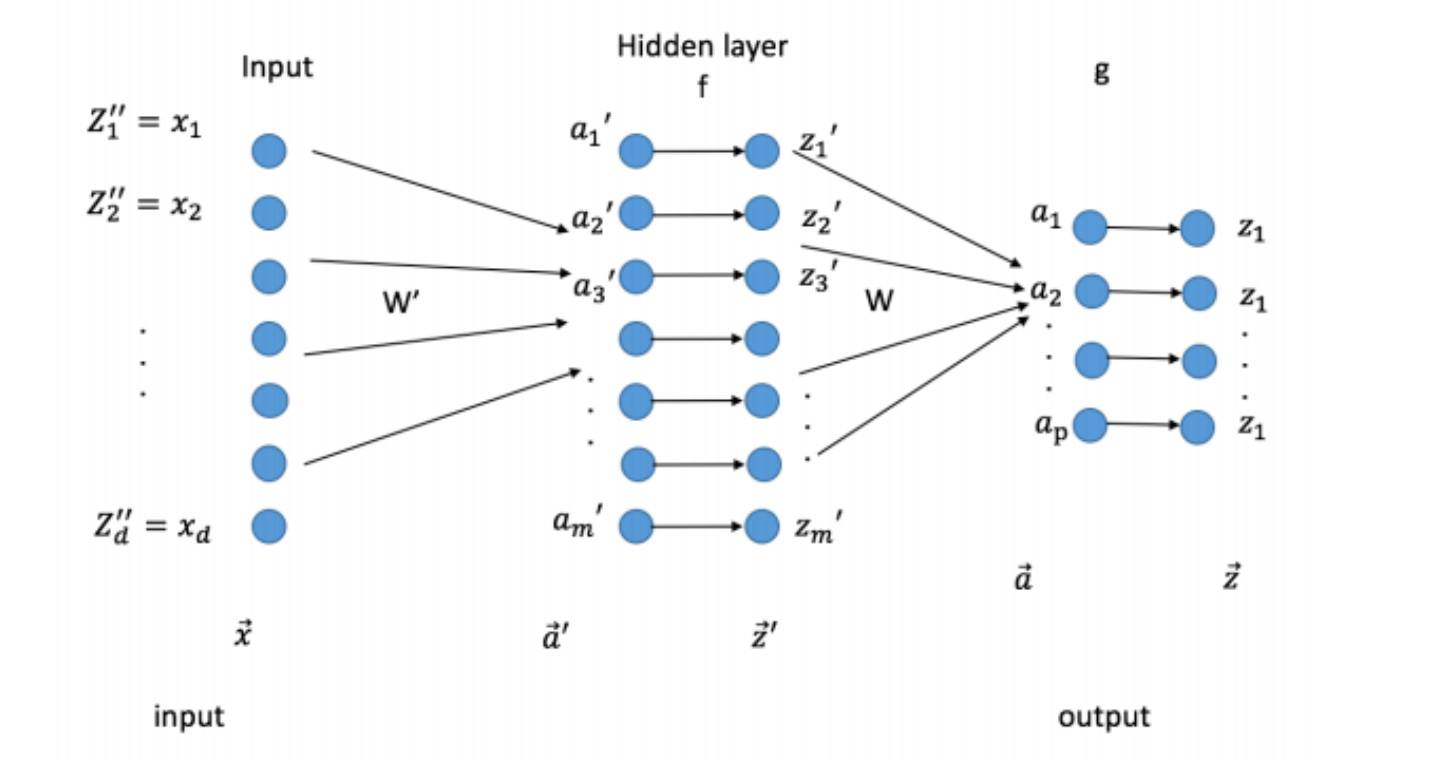


##### In order to accelerate our nn let us use GPU

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Your device is: {}'.format(device))

Your device is: cpu


In [ ]:
model = nn.Sequential(
    nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
    nn.Linear(input_shape, input_shape//2),
    nn.ReLU(),
    nn.Linear(input_shape//2, input_shape//4),
    nn.ReLU(),
    nn.Linear( input_shape//4, num_classes),

).to(device)


# do not change the code in the block below
# __________start of block__________
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()
# __________end of block__________

#### Let us plot the loss

In [ ]:
# do not change the code in the block below
# __________start of block__________
def plot_train_process(train_loss, val_loss, val_accuracy):
    clear_output(True)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))


    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    plt.show()
    # __________end of block__________

In [ ]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=392, bias=True)
  (2): ReLU()
  (3): Linear(in_features=392, out_features=196, bias=True)
  (4): ReLU()
  (5): Linear(in_features=196, out_features=10, bias=True)
)

In [ ]:
model[1]

Linear(in_features=784, out_features=392, bias=True)

In [ ]:
model[1].weight - lr * model[1].weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
model[1].bias.grad

In [ ]:
# do not change the code in the block below
# __________start of block__________
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, build_plot=True):
    train_loss = []
    val_loss = []
    val_accuracy = []


    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
          #zero grad
            opt.zero_grad()

            # to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)

            loss =loss_func(predictions, y_batch)
            print('LOSS VALUE',loss.item())
            print('WEIGHTS',model[1].weight)
            print('GRADS BEFORE BACKWARD', model[1].weight.grad)
            #back step
            loss.backward()
            print('GRADS AFTER BACKWARD', model[1].weight.grad)
            # optimizer step
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_func(predictions, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        if build_plot:
            plot_train_process(train_loss, val_loss, val_accuracy)
    return train_loss, val_loss, val_accuracy
# __________end of block__________

In [ ]:

n_epochs_1 = 25

train_loss, val_loss, val_accuracy = train_model(
    model,
    train_loader,
    test_loader,
    loss_func,
    opt,
    n_epochs_1
)

Выходные данные были обрезаны до нескольких последних строк (5000).
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
LOSS VALUE 1.7696566581726074
WEIGHTS Parameter containing:
tensor([[-0.0333,  0.0258,  0.0197,  ...,  0.0016, -0.0217,  0.0050],
        [ 0.0231, -0.0152,  0.0081,  ..., -0.0338, -0.0053,  0.0126],
        [ 0.0319,  0.0036,  0.0337,  ...,  0.0047,  0.0064, -0.0125],
        ...,
        [ 0.0193,  0.0307,  0.0067,  ...,  0.0055, -0.0033, -0.0252],
        [ 0.0096, -0.0262,  0.0149,  ...,  0.0256,  0.0170,  0.0219],
        [-0.0287, -0.0234,  0.0274,  ...,  0.0213,  0.0184,  0.0293]],
       requires_grad=True)
GRADS BEFORE BACKWARD None
GRADS AFTER BACKWARD tensor([[ 0.0000e+00,  0.0000e+00, -2.2034e-07,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00

KeyboardInterrupt: 

In [ ]:
print(f"accuracy: {val_accuracy[-1]:.3f}")
assert max(val_accuracy) >= 0.885, 'Try changing the architecture'

accuracy: 0.671


AssertionError: Try changing the architecture

### Задача №2: Переобучите сеть.
Постройте сеть и переобучите ее под обучающую выборку. Для переобучения вы можете увеличить число параметров/слоев/шагов обучения. Удостоверьтесь, что значение функции потерь начинает возрастать на тестовой выборке с некоторого момента, в то время как на обучающей оно продолжает падать.

__Пожалуйста, не меняйте оптимизатор и learning rate в данном задании.__ Это упростит вам задачу.

In [ ]:
model_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 392),
    nn.ReLU(),
    nn.Linear(392, 10)

).to(device)

# do not change the code in the block below
# __________start of block__________
opt_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
# __________end of block__________

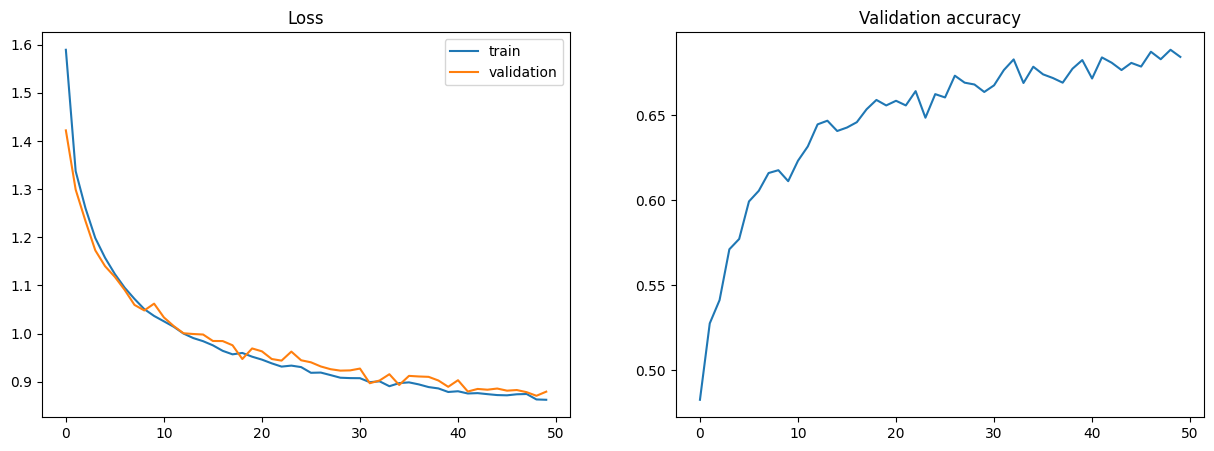

In [ ]:
n_epochs_2 = 50 #>= 35 epochs, 50-100 recommended

assert n_epochs_2 >= 35, 'Try at least 25 epochs'
train_loss_2, val_loss_2, val_accuracy_2 = train_model(
    model_2,
    train_loader,
    test_loader,
    loss_func,
    opt_2,
    n_epochs_2
)

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert len(val_loss_2) >= 35, 'The number of epochs should not be less than 35'
assert np.mean(val_loss_2[10:15]) <= np.mean(val_loss_2[-10:]), 'The network should be overfitting'

out_dict['train_loss_2'] = train_loss_2
out_dict['val_loss_2'] = val_loss_2
out_dict['val_accuracy_2'] = val_accuracy_2
out_dict['model_2'] = [str(x) for x in list(model_2)]
# __________end of block__________